TP Final CoderHouse - NLP & Deep Learning  

Curso Data Science 3

Alumna : Daniela Dito

Dataset: News_Category_Dataset_v3 (Kaggle)

Consigna:

La Entrega Final constará de dos partes. Un mínimo requerido respecto a **NLP**.Deberás entregar un dataset del estilo texto (libro, paper, documento, colección de tweets, etc) donde se desarrollen de mínima dos de las tareas más usuales de preprocesamiento de NLP.

También un mínimo requerido de **Deep Learning** donde puedas construir tu primera red neuronal sencilla, lo que cubrirá la segunda actividad hacia la Entrega Final.

Para la Entrega Final deberás elegir una de las dos actividades y profundizar en el mismo, ya sea realizando un análisis de texto sobre la actividad de NLP o mejorando la red, vía adición de capas, en el de Deep Learning.

En este proyecto se aborda un flujo completo de procesamiento de lenguaje natural (NLP) y aprendizaje profundo (Deep Learning) utilizando el dataset News_Category_Dataset_v3 de Kaggle.

El objetivo principal es aplicar técnicas fundamentales de preprocesamiento de texto, exploración de datos y análisis de sentimiento, para luego construir una primera red neuronal recurrente que permita clasificar noticias en distintas categorías.

La notebook se encuentra organizada en secciones:

**Librerías**: instalación e importación de las herramientas necesarias.

**Carga del dataset**: lectura y concatenación del dataset en un único DataFrame para su análisis.

**Análisis exploratorio (EDA)**: exploración inicial del corpus de noticias con visualizaciones y generación de insights.

**Preprocesamiento NLP**: limpieza del texto, tokenización, lematización y normalización de datos.

**Análisis de sentimiento**: estimación de la polaridad de los textos como ejemplo de tarea de NLP.

**Red neuronal recurrente (LSTM)**: construcción y entrenamiento de un modelo básico de clasificación de noticias, que constituye el bloque de Deep Learning requerido en la consigna.

#1 Librerias

In [2]:
# Importamos librerias
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns

import re
import nltk
import spacy
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter # Import Counter from collections
from spacy import displacy

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer   # herramienta de scikit-learn que transforma texto en una matriz numérica (bolsa de palabras).
from datetime import datetime

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

#Carga del Dataset

In [3]:
# Kaggle no da acceso directo a sus Datasets con una url, por lo tanto necesito usar su API para descargar
#!pip install kaggle

# Observo en que carpeta se descargo el archivo
#print(os.getcwd())

In [4]:
# Reinstalo gdown
#!pip install gdown --force-reinstall

In [5]:
# OPCION DE CARGA 1: Directametne en VS con Tokens de Kaggle y API
#!kaggle datasets download -d rmisra/news-category-dataset -p ./datasets   # -p ./datasets → carpeta donde lo guarda


# OPCION 2 para disponibilizar Dataset a profesores de Coderhouse
!gdown --id 1IiIIuJAjbAVQwW3LQCvQFxKbTvSga041


/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1IiIIuJAjbAVQwW3LQCvQFxKbTvSga041
From (redirected): https://drive.google.com/uc?id=1IiIIuJAjbAVQwW3LQCvQFxKbTvSga041&confirm=t&uuid=4d2a290b-8f4c-4f75-aa7f-defc2d16db77
To: /content/news-category-dataset.zip
100% 27.8M/27.8M [00:00<00:00, 55.2MB/s]


In [6]:
# Verifico el contenido del directorio
# !dir

In [7]:
# Opcion 1 acceso a Dataset en carpeta dataset/news
"""
import zipfile

# Ruta al archivo descargado
zip_path = "./datasets/news-category-dataset.zip"

# Descomprimir en carpeta "datasets/news"
with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall("./datasets/news")

# Cargar JSON en Pandas
df = pd.read_json("./datasets/news/News_Category_Dataset_v3.json", lines= True)
"""


'\nimport zipfile\n\n# Ruta al archivo descargado\nzip_path = "./datasets/news-category-dataset.zip"\n\n# Descomprimir en carpeta "datasets/news"\nwith zipfile.ZipFile(zip_path, "r") as zip_ref:\n    zip_ref.extractall("./datasets/news")\n\n# Cargar JSON en Pandas\ndf = pd.read_json("./datasets/news/News_Category_Dataset_v3.json", lines= True)\n'

In [8]:
# Opción 2: Acceso a Utilizar por profesores de Coderhouse
import zipfile

# Ruta al archivo descargado
zip_path = "news-category-dataset.zip"

# Descomprimir en carpeta "datasets"
with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall("./datasets")

# Cargar JSON en Pandas
df = pd.read_json("./datasets/News_Category_Dataset_v3.json",
                  lines= True,   # Si no se pone lines=True, pandas intentaría leer todo el archivo como un único objeto JSON, lo cual fallaría en este caso.
                  chunksize=100000)  # solo 100000 chunks

Al usar chunksize no obtengo un dataframe, sino un iterador de chunks de pandas. df no es un DataFrame, es un JsonReader, que se comporta como un generador que devuelve DataFrames de a 100.000 filas.
Cuando usamos:

* `chunksize=100000` hace que **Pandas no cargue todo el dataset de una vez**.
* En su lugar devuelve un **iterador de DataFrames** (chunks), cada uno con \~100.000 filas.
* Para este dataset se generan 3 chunks:

  * 100.000 filas
  * 100.000 filas
  * 9.527 filas

Cada vez que hacés next(df) obtenés un DataFrame con 100.000 filas. **Ventaja de usar `chunksize`**: permite procesar archivos grandes **por partes**, evitando sobrecargar la memoria RAM.

In [9]:
# Convierto a Dataframe
dfs = []
for chunk in pd.read_json("./datasets/News_Category_Dataset_v3.json", lines=True, chunksize=100000):
    dfs.append(chunk)

# Unir todos los DataFrames en uno solo (Si queremos reconstruir el DataFrame completo, concatenamos los chunks)
df = pd.concat(dfs, ignore_index=True)

# Revisar
print(type(df))   # <class 'pandas.core.frame.DataFrame'>
print(df.shape)   # cantidad de filas y columnas
# Estructura del Dataset
print(f"El Dataset cuenta con {df.shape[0]} filas y {df.shape[1]} columnas.")


<class 'pandas.core.frame.DataFrame'>
(209527, 6)
El Dataset cuenta con 209527 filas y 6 columnas.


El archivo contiene **209.527 noticias** y **6 columnas** (`category`, `headline`, `authors`, `link`, `short_description`, `date`).


In [10]:
df.describe(include='all')

,link,headline,category,short_description,authors,date
count,209527,209527,209527,209527,209527,209527
unique,209486,207996,42,187022,29169,NaN
top,https://www.huffingtonpost.comhttp://stylelike...,Sunday Roundup,POLITICS,,,NaN
freq,2,90,35602,19712,37418,NaN
mean,NaN,NaN,NaN,NaN,NaN,2015-04-30 00:44:14.344308736
min,NaN,NaN,NaN,NaN,NaN,2012-01-28 00:00:00
25%,NaN,NaN,NaN,NaN,NaN,2013-08-10 00:00:00
50%,NaN,NaN,NaN,NaN,NaN,2015-03-16 00:00:00
75%,NaN,NaN,NaN,NaN,NaN,2016-11-01 00:00:00
max,NaN,NaN,NaN,NaN,NaN,2022-09-23 00:00:00


##Análisis Exploratorio (EDA)

In [11]:
# Columnas disponibles
print(df.columns)

Index(['link', 'headline', 'category', 'short_description', 'authors', 'date'], dtype='object')


In [12]:
# Visualizaciones en general

def eda_visualizations(df, num_cols=None, cat_cols=None):
    """
    Genera un análisis visual exploratorio del DataFrame:
    - Histogramas / distribuciones para variables numéricas
    - Boxplots para variables numéricas agrupadas por categorías (si hay categóricas)
    - Scatterplots entre pares de numéricas
    - Heatmap de correlación de Pearson entre numéricas

    Parámetros:
    -----------
    df : pd.DataFrame
        DataFrame de entrada
    num_cols : list, optional
        Lista de columnas numéricas. Si es None, se detectan automáticamente.
    cat_cols : list, optional
        Lista de columnas categóricas. Si es None, se detectan automáticamente.
    """

    # Detectar columnas si no están definidas
    if num_cols is None:
        num_cols = df.select_dtypes(include=["int64", "float64"]).columns.tolist()
    if cat_cols is None:
        cat_cols = df.select_dtypes(include=["object", "category"]).columns.tolist()

    print("Variables numéricas:", num_cols)
    print("Variables categóricas:", cat_cols)

    # Distribuciones
    for col in num_cols:
        plt.figure(figsize=(6,4))
        sns.histplot(df[col].dropna(), kde=True, bins=30, color="skyblue")
        plt.title(f"Distribución de {col}")
        plt.xlabel(col)
        plt.ylabel("Frecuencia")
        plt.show()

    # Boxplots
    if cat_cols:
        for num in num_cols:
            for cat in cat_cols:
                if df[cat].nunique() < 20:  # evitar categoricas con demasiados valores
                    plt.figure(figsize=(10,5))
                    sns.boxplot(x=cat, y=num, data=df, palette="Set2")
                    plt.title(f"Boxplot de {num} por {cat}")
                    plt.xticks(rotation=45)
                    plt.show()


    # Scatterplots

    if len(num_cols) >= 2:
        sns.pairplot(df[num_cols], diag_kind="kde")
        plt.suptitle("Scatterplots entre variables numéricas", y=1.02)
        plt.show()

    # Heatmap de correlación de Pearson

    if len(num_cols) > 1:
        corr = df[num_cols].corr(method="pearson")
        plt.figure(figsize=(8,6))
        sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
        plt.title("Matriz de correlación de Pearson")
        plt.show()


In [13]:
eda_visualizations(df)


Variables numéricas: []
Variables categóricas: ['link', 'headline', 'category', 'short_description', 'authors']


Esa función de EDA (eda_visualizations) está pensada para datasets tabulares tradicionales estructurados donde tenemos variables numéricas y categóricas bien definidas. En cambio, en NLP, los datos son principalmente texto, y el texto necesita ser transformado en representaciones numéricas (longitud, frecuencia de palabras, embeddings) antes de poder visualizarse con histogramas, boxplots o correlaciones.

## Análisis Exploratorio de Datos (EDA) en NLP

Para entender la naturaleza del texto antes de aplicar modelos, analizaremos:

1. **Distribución de longitudes de texto (text_length)**: muestra cuántas palabras o caracteres tienen las oraciones/documentos.

2. **Distribución de clases (target = category)**: si el dataset está etiquetado, es importante revisar si las clases están balanceadas o si existe desbalance (clases poco representadas).

3. **Visualización de nubes de palabras WordCloud (nube de palabras)**: permite ver de manera visual las palabras más frecuentes en el corpus.

4. **Conteo de palabras más frecuentes (word frequencies, n-grams)**: gráfico de barras con las palabras más comunes.

5. **Análisis de stopwords y rarewords.**

6. **Matriz de co-ocurrencia de palabras** o heatmaps de correlación de términos.

7. **Embeddings reducidos con PCA/t-SNE/UMAP** para ver la estructura semántica.

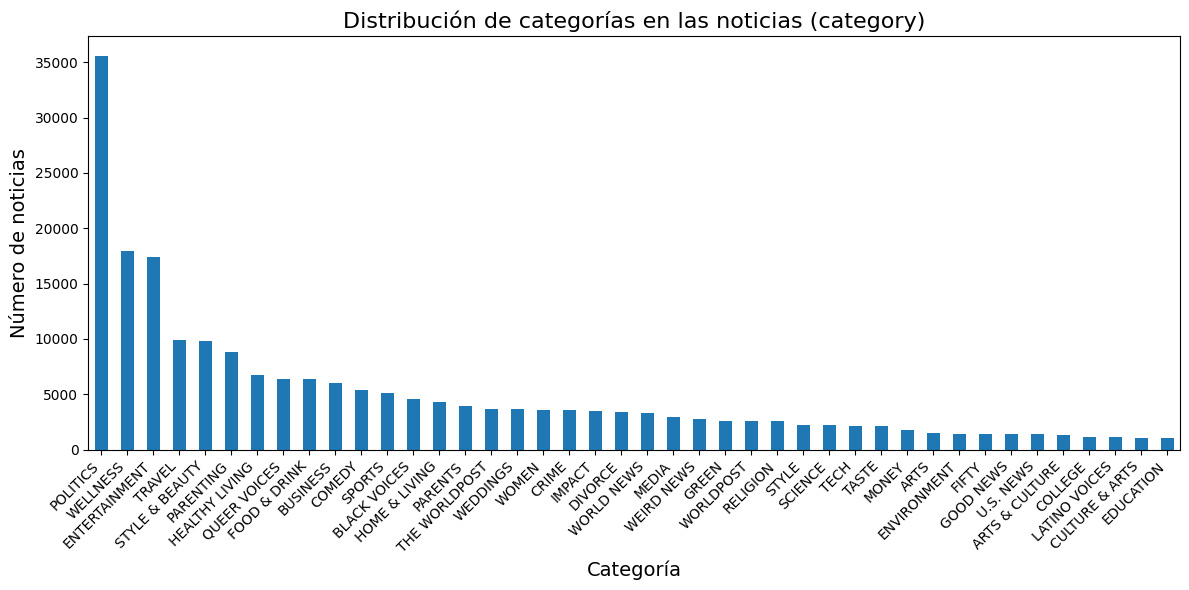

In [14]:
# Insight 1: Distribución de categorías (feature category)

plt.figure(figsize=(12,6))
ax = df['category'].value_counts().plot(kind='bar')

# Títulos usando el objeto ax
ax.set_title("Distribución de categorías en las noticias (category)", fontsize=16)
ax.set_xlabel("Categoría", fontsize=14)      # etiqueta del eje X
ax.set_ylabel("Número de noticias", fontsize=14)

# Mejoras de ticks
plt.xticks(rotation=45, ha='right', fontsize=10)

# Ajustar layout para evitar recortes
plt.tight_layout()

plt.show()


In [15]:
# Insight 1: Categoría más frecuente
print("Insight 1: La categoría más común es:", df["category"].value_counts().idxmax())

Insight 1: La categoría más común es: POLITICS


**Descripción:** El gráfico de barras muestra la distribución de noticias por categorías. En el eje horizontal están las categorías de noticias (Politics, Wellness, Entertainment, etc.) y en el eje vertical está la cantidad de noticias en cada categoría.


**Desbalance / asimetría a la izquierda**

Se observa que unas pocas categorías tienen muchas noticias, mientras que la mayoría tienen relativamente pocas. Por ejemplo, Politics tiene el mayor volumen, muy por encima de todas las demás.
Luego viene Wellness, Entertainment, Travel, Style & Beauty, Parenting, etc., con cantidades intermedias.

**Tipo de distribución:** *distribución muy sesgada hacia la izquierda:* muchas pocas categorías con valores altos, muchas con valores bajos (“long tail”). No es simétrica, ni uniforme.

**Interpretación / implicaciones:**

Para entrenar un modelo de clasificación, el desbalance de clases es un problema: el modelo podría sesgarse hacia las categorías con más ejemplos (Politics, etc.). Sería importante usar técnicas como re-muestreo (oversampling/undersampling), ponderaciones, data augmentation, o ajustar la métrica para tener en cuenta ese desbalance.


Longitud promedio de las descripciones: 19.66902594892305


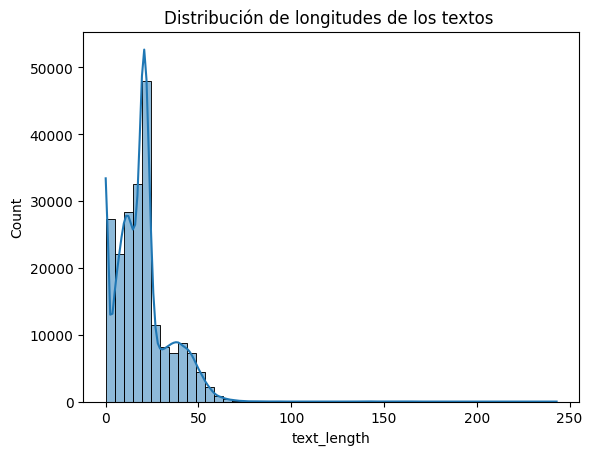

In [16]:
# Insight 2: Longitud promedio de los textos
"""
Crea una columna con la cantidad de palabras en cada texto.
Calcula la media de esas longitudes.
Grafica un histograma con densidad para visualizar la distribución.
"""
df['text_length'] = df['short_description'].apply(lambda x: len(str(x).split()))  # agrego columna text_lenght
print("Longitud promedio de las descripciones:", df['text_length'].mean())

sns.histplot(df['text_length'], bins=50, kde=True)
plt.title("Distribución de longitudes de los textos ")
plt.show()

El gráfico (**histograma con una curva de densidad** (`kde=True`)) muestra la distribución de la longitud de los textos en la columna `short_description`, donde la longitud se mide por el número de palabras.

* **Eje X (`text_length`)**: Representa el número de palabras en cada descripción. Va desde casi 0 hasta 250 palabras.
* **Eje Y (`Count`)**: Indica la frecuencia (cuántas descripciones tienen una longitud determinada).

1.  **Concentración Principal**: La mayoría de las descripciones tienen una longitud relativamente corta. El pico más alto del histograma se encuentra **alrededor de las 20 a 30 palabras**, descripciones son concisas.

2.  **Dispersión**: La mayoría de los datos se agrupan en un rango corto, probablemente entre 10 y 50 palabras. La frecuencia de descripciones más largas (más de 50 palabras) disminuye drásticamente, lo que indica que **existen muy pocas descripciones extensas**.

3.  **Valor Atípico (Outliers)**: Aunque la mayoría de los textos son cortos, el histograma muestra una "cola" larga que se extiende hasta casi 250 palabras. Esto significa que **hay algunas descripciones excepcionalmente largas**, aunque son raras.

**Conclusión del Insight**

Este análisis nos dice que la mayoría de los textos en la columna `short_description` son **breves y estandarizados**. La longitud promedio está fuertemente influenciada por la alta concentración de textos cortos.

In [17]:
 df.groupby("category")["text_length"].mean().sort_values(ascending=False).head(10)

,text_length
category,
FIFTY,33.656674
WELLNESS,30.904820
PARENTING,29.701172
EDUCATION,27.783037
MONEY,27.341686
TRAVEL,26.435657
IMPACT,26.082951
WEDDINGS,25.780728
DIVORCE,25.761529


In [18]:
# Insight 3: Categoría con descripciones más largas

# Agrupa el DataFrame por categoría
longest_cat = df.groupby("category")["text_length"].mean().idxmax() # Calcula el promedio de long. de las descripciones por c/categoría y devuelve el índice.
longest_val = df.groupby("category")["text_length"].mean().max()

# Mostrar categoría + promedio
print(f"Insight 4: La categoría con descripciones más largas es: {longest_cat}, con un promedio de palabras de {longest_val:.2f}")


Insight 4: La categoría con descripciones más largas es: FIFTY, con un promedio de palabras de 33.66


In [19]:
# # Insight 4: Frecuencia de palabras.

from wordcloud import WordCloud, STOPWORDS
def eda_nlp(df, text_col="short_description", target_col="category", top_n=20):
    """
    Realiza un análisis exploratorio por Wodrcloud y frecuencia de palabras en un DataFrame de texto.

    Parámetros:
    df : pd.DataFrame
        DataFrame de entrada.
    text_col : str
    """

    #  WordCloud de todo el corpus
    # -----------------------------
    text_data = " ".join(df[text_col].astype(str).tolist())
    wordcloud = WordCloud(width=800, height=400,
                          background_color="white",
                          stopwords=set(STOPWORDS),
                          max_words=100).generate(text_data)

    plt.figure(figsize=(10,6))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title("WordCloud de descripciones")
    plt.show()


    #  Frecuencia de palabras
    # -----------------------------
    all_words = text_data.lower().split()
    word_freq = Counter(all_words)
    common_words = word_freq.most_common(top_n)  # definido en las 20 más frecuentes
    words, counts = zip(*common_words)

    plt.figure(figsize=(10,5))
    sns.barplot(
              x=list(counts),
              y=list(words),
              hue=list(words),    # cada palabra es un "grupo"
              palette="viridis",
              dodge=False,        # para que no se dupliquen las barras
              legend=False        # para que no aparezca una leyenda redundante
          )

    plt.title(f"Top {top_n} palabras más frecuentes")
    plt.xlabel("Frecuencia")
    plt.ylabel("Palabra")
    plt.show()

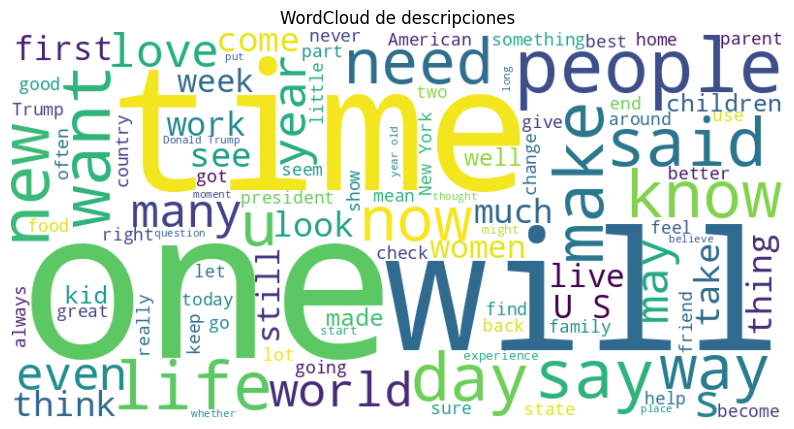

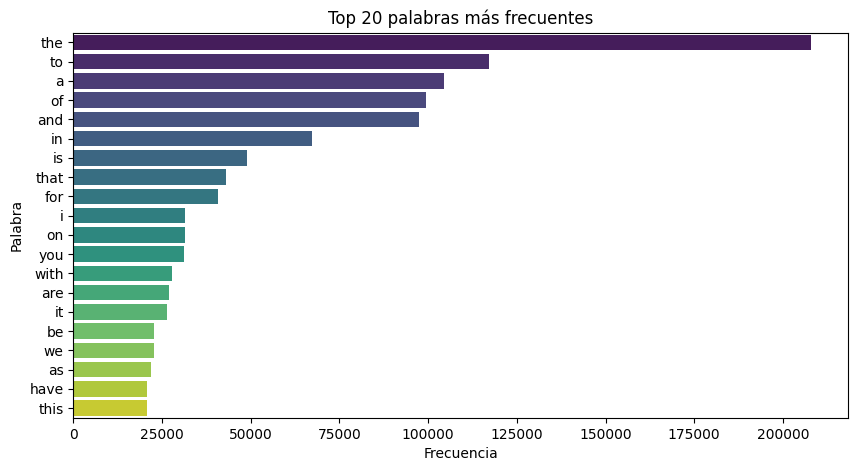

In [20]:
eda_nlp(df)

Muestra que las 10 palabras más comunes son palabras de parada (en inglés: stop words). Se necesita un preprocesamiento adicional. Para obtener un insight real sobre los temas o el contenido de las descripciones, se deben eliminar estas palabras de parada y quizás también la puntuación y los números.

Observamos que dentro de rarewords incluye palabras con los signos de puntuación.

## Preprocesamiento


In [21]:
# # Limpieza del corpus

# short_df = df.head(100000)       # Se seleccionan 100.000 filas del DataFrame original (df)

# # Definimos una función que busca las palabras más frecuentes. #  n: cantidad de palabras más frecuentes que queremos.
# def get_top_n_words(corpus, n=1, k=1):         # k: tamaño del n-grama (1=palabras individuales, 2=pares de palabras, etc.)
#     t1 = datetime.now()                        # guarda el tiempo de inicio, útil si quisiéramos medir cuánto tarda.
#     vec = CountVectorizer(ngram_range=(k, k), stop_words="english")  # ngram_range=(k, k) → si k=1, toma palabras sueltas; si k=2, toma pares de palabras consecutivas, etc.
#     bag_of_words = vec.fit_transform(corpus)                         # fit_transform transforma el corpus en una matriz dispersa (sparse matrix):
#     sum_words = bag_of_words.sum(axis=0)                             # Bolsa de palabras: filas-> doumentos, columnas-> palabras únicas encontradas
#     words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]  # vec.vocabulary_ es un diccionario {palabra: índice de columna}, Se construye una lista de tuplas:(palabra, frecuencia_global), sum_words[0, idx] accede a la frecuencia de esa palabra en la matriz.
#     words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)                   # Ordena las tuplas por frecuencia (x[1]), de mayor a menor.
#     return words_freq[:n]

In [22]:
# # Todos los reviews                                         # short_df["headline"] → columna con los titulares (corpus de texto)
# common_words = get_top_n_words(short_df["headline"], 20, 1) # Parámetros : 20 palabras más frecuentes, de k=1 unigramas ( palabras indiv.)
# for word, freq in common_words:
#     print(word, freq)                                      # Resultado: una lista de tuplas (palabra, frecuencia).

# df_common_words = pd.DataFrame(common_words, columns=["words", "count"])
# df_common_words.groupby("words").sum()["count"].sort_values(ascending=False).plot(
#     kind="bar", title="Top 20 words from all reviews"
# )

In [23]:
# common_words   # lista de tuplas (palabra, frecuencia).

In [24]:
# short_df.head()

In [25]:
# get_top_n_words(short_df, 2,1)

A continuación utilizamos la funcion limpiar_texto basada en  bibliotecas de Python **`nltk` (Natural Language Toolkit)** y **`re` (Expresiones Regulares)**.

* **`nltk`**: Se encarga de las tareas más avanzadas de procesamiento del lenguaje natural (NLP), como la **tokenización** (dividir el texto en palabras), la eliminación de **_stopwords_** y la **lematización** (reducir las palabras a su forma base).
* **`re`**: **expresiones regulares**,para eliminar caracteres especiales y puntuación.

1.  **Convierte a minúsculas**: Transforma todo el texto a minúsculas, asegurando que, por ejemplo, "Apple" y "apple" sean tratadas como la misma palabra.
2.  **Elimina caracteres especiales**: Elimina la puntuación, símbolos y números, dejando solo letras y espacios.
3.  **Tokeniza**: Divide el texto en una lista de palabras individuales.
4.  **Lematiza y elimina _stopwords_**: Recorre cada palabra de la lista. Si la palabra no es una _stopword_ (como "a", "an", "the"), la lematiza, es decir, la reduce a su forma raíz. Por ejemplo, "running" se convierte en "run".
5.  **Une las palabras**: Finalmente, junta las palabras limpias de nuevo en una sola cadena de texto.

In [26]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def limpiar_texto(texto):
    # Pasar a minúsculas
    texto = texto.lower()

    # Eliminar caracteres especiales
    texto = re.sub(r'[^a-zA-Z\s]', '', texto)

    # Tokenizar
    tokens = nltk.word_tokenize(texto)              # tokenización

    # Eliminar stopwords y lematizar
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)

df['clean_text'] = df['short_description'].astype(str).apply(limpiar_texto)       # NUeva columna con texto limpio
df[['short_description', 'clean_text']].head()

,short_description,clean_text
0,Health experts said it is too early to predict...,health expert said early predict whether deman...
1,He was subdued by passengers and crew when he ...,subdued passenger crew fled back aircraft conf...
2,"""Until you have a dog you don't understand wha...",dog dont understand could eaten
3,"""Accidentally put grown-up toothpaste on my to...",accidentally put grownup toothpaste toddler to...
4,Amy Cooper accused investment firm Franklin Te...,amy cooper accused investment firm franklin te...


In [27]:
# # Creamos un CountVectorizer que: Divide el texto en tokens (palabras) y quita palabras sin carga semantica ( stopwords)
# vec = CountVectorizer(ngram_range=(1, 1), stop_words="english")   # Se inicializa un CountVectorizer que analiza palabras individuales.
# bag_of_words = vec.fit_transform(short_df["headline"])            # fit_transform(short_df["headline"]) → genera la matriz dispersa de conteos de palabras en los titulares (headline).

In [28]:
# bag_of_words.sum(axis=0)    # suma columna por columna, es decir, cuenta cuántas veces aparece cada palabra en todo el corpus.
                            # bag_of_words.sum(axis=0) → devuelve un vector con las frecuencias totales de cada palabra en las 100.000 noticias.

Es una matriz fila con las frecuencias de cada palabra del vocabulario.

El orden depende de cómo CountVectorizer indexó las palabras en vocabulary_.

#  Análisis de Sentimiento (NLP)

In [29]:
#df['clean_text']

In [30]:
#!pip install textblob

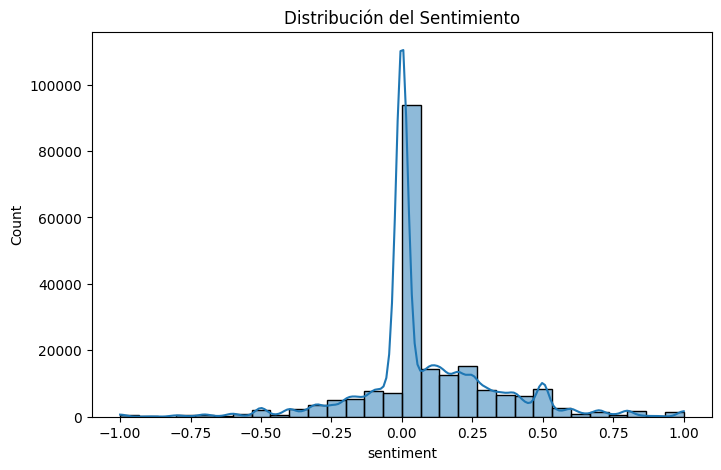

                                   short_description  sentiment
0  Health experts said it is too early to predict...   0.118182
1  He was subdued by passengers and crew when he ...   0.000000
2  "Until you have a dog you don't understand wha...   0.000000
3  "Accidentally put grown-up toothpaste on my to...   0.000000
4  Amy Cooper accused investment firm Franklin Te...  -0.233333


In [31]:
from textblob import TextBlob

def obtener_sentimiento(texto):
    return TextBlob(texto).sentiment.polarity               # Polaridad: 1 Positiva, -1 Negativa
                                                            # Subjetividad: "0"( objetivo,un hecho), "1" (subjetivo, una opinion)

df['sentiment'] = df['clean_text'].apply(obtener_sentimiento)    # método .apply() de pandas para aplicar la función obtener_sentimiento a c/fila de la columna 'clean_text'. El resultado (la polaridad de cada texto) se guarda en una nueva columna llamada 'sentiment'.

plt.figure(figsize=(8,5))
sns.histplot(df['sentiment'], bins=30, kde=True)
plt.title("Distribución del Sentimiento")
plt.show()

print(df[['short_description', 'sentiment']].head())

El eje X representa la **polaridad del sentimiento** (de -1.0 a 1.0) y el eje Y, el recuento o la frecuencia de los textos que caen en ese rango.

Predominio de la neutralidad: La característica más notable es el pico central extremadamente alto. Esto indica que una gran mayoría de los textos analizados tienen una polaridad de sentimiento cercana a cero (0.0), su tono es neutral. Esto es común en textos que son puramente informativos o que no expresan una opinión fuerte.

Sesgo positivo: Aunque la neutralidad domina, la distribución de los textos positivos (valores a la derecha del 0) es más amplia y tiene una frecuencia mayor que la de los textos negativos. Hay una "cola" más larga y una mayor cantidad de barras en el rango de 0.25 a 0.75, lo que sugiere que hay más textos con un sentimiento moderadamente positivo que textos con un sentimiento moderadamente negativo.

Baja cantidad de textos extremos: Tanto los sentimientos extremadamente positivos (cerca de 1.0) como los extremadamente negativos (cerca de -1.0) son muy poco frecuentes. Las barras en los extremos del gráfico son muy bajas, lo que indica que pocos textos expresan un sentimiento muy fuerte.

En resumen, el gráfico revela que la mayoría de los textos no expresan un sentimiento claro. De aquellos que sí lo hacen, hay un ligero predominio de opiniones positivas sobre las negativas, aunque las opiniones muy fuertes son raras.


--- Conteo de Categorías de Sentimiento ---
Polarity
Neutro      116440
Positivo     69961
Negativo     23126
Name: count, dtype: int64


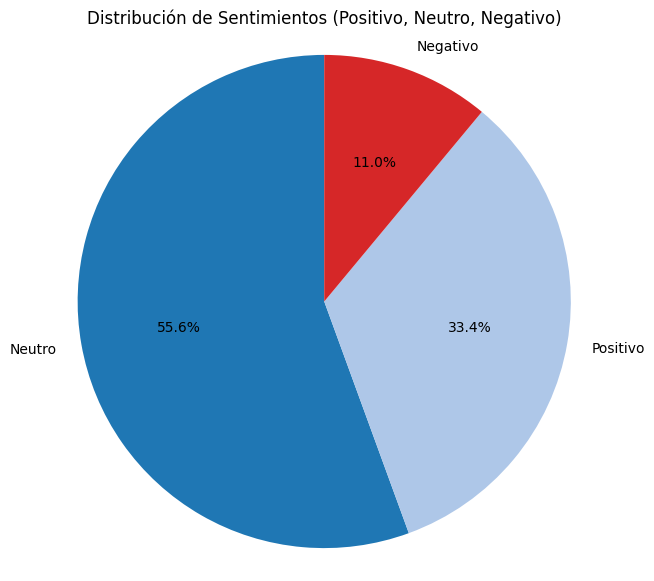


--- Vista previa del DataFrame mejorado ---
                                   short_description  sentiment  Polarity
0  Health experts said it is too early to predict...   0.118182  Positivo
1  He was subdued by passengers and crew when he ...   0.000000    Neutro
2  "Until you have a dog you don't understand wha...   0.000000    Neutro
3  "Accidentally put grown-up toothpaste on my to...   0.000000    Neutro
4  Amy Cooper accused investment firm Franklin Te...  -0.233333  Negativo


In [32]:
#  Crear la columna 'Polarity' con categorías
def clasificar_polaridad(score):
    """
    Clasifica un puntaje de polaridad en 'Positivo', 'Neutro' o 'Negativo'.
    """
    if score > 0.1:
        return 'Positivo'
    elif score < -0.1:
        return 'Negativo'
    else:
        return 'Neutro'

df['Polarity'] = df['sentiment'].apply(clasificar_polaridad)

#  Conteo de valores de la nueva columna 'Polarity' ---
print("\n--- Conteo de Categorías de Sentimiento ---")
print(df['Polarity'].value_counts())

# Visualización con un gráfico de torta ---
polarity_counts = df['Polarity'].value_counts()            # Obtener los conteos para el gráfico
labels = polarity_counts.index
sizes = polarity_counts.values

# Crear el gráfico de torta
plt.figure(figsize=(7, 7))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=['#1F77B4', '#AEC7E8', '#D62728'])
plt.title("Distribución de Sentimientos (Positivo, Neutro, Negativo)")
plt.axis('equal')  # Asegura que el círculo sea perfecto
plt.show()

# Mostrar las primeras filas con las nuevas columnas ---
print("\n--- Vista previa del DataFrame mejorado ---")
print(df[['short_description', 'sentiment', 'Polarity']].head())

* **Predominio de la neutralidad:** El hallazgo más significativo es que la mayoría de los textos (el **55.6%**) tiene un sentimiento **neutro**. Esto es común en textos informativos, descripciones o datos sin una carga emocional.

* **Sentimiento positivo en segundo lugar:** La segunda categoría más grande es el sentimiento **positivo**, que representa un **33.4%**.


# Spacy

In [33]:
# Cargar el modelo de spaCy para inglés. Es más eficiente que NLTK para esta tarea ('en_core_sm' es la versión pequeña)
try:
    nlp = spacy.load("en_core_web_sm")   #  carga el modelo pre-entrenado para inglés, incluye la lematización y la lista de stopwords en inglés.
except OSError:
    print("Downloading 'en_core_web_sm' model for spaCy...")
    from spacy.cli import download
    download("en_core_web_sm")
    nlp = spacy.load("en_core_web_sm")

def limpiar_texto_mejorado(texto):
    """
    Función optimizada para limpiar y preprocesar texto en inglés.
    Incluye minúsculas, eliminación de caracteres no alfabéticos, stopwords y lematización.
    """
    # 1. Manejar textos que no son cadenas (por ejemplo, NaN).Esto previene errores si hay valores faltantes o no-texto en la columna.
    if not isinstance(texto, str):
        return ""

    # 2. Pasar a minúsculas
    texto = texto.lower()

    # 3. Eliminar caracteres no alfabéticos (excepto espacios) Usa una expresión regular para limpiar la puntuación y números.
    texto = re.sub(r'[^a-z\s]', '', texto)

    # 4. Procesar el texto con el pipeline de spaCy: spaCy maneja la tokenización, detección de stopwords y la lematización.
    doc = nlp(texto)

    # 5. Lematizar y eliminar stopwords
    # Se crea una lista de tokens limpios:
    # - `token.lemma_` obtiene la forma base de la palabra (ej: 'running' -> 'run').
    # - `not token.is_stop` filtra las palabras comunes sin mucho significado.
    # - `not token.is_space` evita incluir espacios extra.
    tokens_limpios = [token.lemma_ for token in doc if not token.is_stop and not token.is_space]

    # 6. Unir los tokens limpios en una sola cadena.
    return " ".join(tokens_limpios)

In [ ]:
# Llamamos a la función
df['clean_text_spacy'] = df['short_description'].astype(str).apply(limpiar_texto_mejorado)
print(df[['short_description', 'clean_text_spacy']].head())

In [ ]:
df['sentiment_spacy'] = df['clean_text_spacy'].apply(obtener_sentimiento)    # método .apply() de pandas para aplicar la función obtener_sentimiento a c/fila de la columna 'clean_text'. El resultado (la polaridad de cada texto) se guarda en una nueva columna llamada 'sentiment'.

plt.figure(figsize=(8,5))
sns.histplot(df['sentiment_spacy'], bins=30, kde=True)
plt.title("Distribución del Sentimiento con Spacy")
plt.show()

print(df[['short_description', 'sentiment_spacy']].head())

In [ ]:
from spacy import displacy

# # Tu código existente para cargar el modelo de spaCy
# try:
#     nlp = spacy.load("en_core_web_sm")
# except OSError:
#     print("Downloading 'en_core_web_sm' model for spaCy...")
#     from spacy.cli import download
#     download("en_core_web_sm")
#     nlp = spacy.load("en_core_web_sm")

# # Tu función de limpieza de texto
# def limpiar_texto_mejorado(texto):
#     if not isinstance(texto, str):
#         return ""
#     texto = texto.lower()
#     texto = re.sub(r'[^a-z\s]', '', texto)
#     doc = nlp(texto)
#     tokens_limpios = [token.lemma_ for token in doc if not token.is_stop and not token.is_space]
#     return " ".join(tokens_limpios)

# # Asumiendo que 'df' ya está cargado. Aquí un ejemplo si no lo tienes:
# data = {'short_description': ["The quick brown fox jumps over the lazy dog.",
#                               "The Empire State Building is in New York.",
#                               "I am going to the movies with my friend."]}
# df = pd.DataFrame(data)

# # Aplica la función de limpieza y crea la nueva columna
# df['clean_text_spacy'] = df['short_description'].astype(str).apply(limpiar_texto_mejorado)

# --- 4. Visualizar un texto limpio con Displacy ---
# Selecciona el primer texto limpio para visualizar
texto_a_visualizar = df['clean_text_spacy'][0]

# Procesa el texto limpio con spaCy nuevamente para obtener un objeto 'doc'
# Nota: La visualización de dependencias será menos útil después de la limpieza ya que eliminamos las palabras que definen la estructura gramatical.
# Sin embargo, la de entidades puede seguir siendo relevante.
doc_limpio = nlp(texto_a_visualizar)

# Visualiza las entidades (personas, lugares, organizaciones, etc.)--> etiquetado de las entidades.
print("Visualización de entidades nombradas del texto limpio:")
displacy.render(doc_limpio, style="ent", jupyter=True)

# Visualiza las dependencias gramaticales del texto limpio
print("\nVisualización de dependencias gramaticales del texto limpio:")
displacy.render(doc_limpio, style="dep", jupyter=True)

# Muestra la columna con los textos originales y limpios
print("\nDataFrame con los textos originales y limpios:")
print(df[['short_description', 'clean_text_spacy']])

In [ ]:
# Extraer automáticamente esas entidades compuestas a partir de la información de dependencias sintácticas del grafo:
doc_limpio = nlp(texto_a_visualizar)

entities = []

for token in doc_limpio:
    # Buscar sustantivos principales
    if token.pos_ in ["NOUN"]:
        # Tomar el núcleo y sus modificadores (izquierda + derecha)
        modifiers = [tok.text for tok in token.lefts if tok.dep_ in ["compound", "amod", "nummod"]]
        phrase = " ".join(modifiers + [token.text])
        entities.append(phrase)

print("Entidades compuestas encontradas:", entities)


## 🎯 Obtención de Entidades Compuestas en NLP:
 **unidades léxicas complejas** formadas por un sustantivo núcleo y sus modificadores (numéricos, adjetivos o compuestos).  
### 🧩 ¿Para qué sirve extraerlas?

1. **Mejorar la representación del texto**  
   - Capturan significados más precisos que las palabras sueltas.  
   - Evitan pérdida de contexto (ej. *“booster order”* ≠ *booster* + *order* por separado).  

2. **Enriquecer el Análisis de Frecuencia**  
   - Permite estudiar la ocurrencia de términos relevantes en lugar de palabras comunes.  

3. **Extracción de información estructurada**  
   - Ayuda a identificar actores, objetos o eventos clave dentro de un corpus  

4. **Mejorar modelos de clasificación o clustering**  
   - Usar entidades compuestas como features puede dar señales más discriminativas.  

5. **Apoyo a tareas de NER (Named Entity Recognition)**  
   - Se pueden complementar las entidades reconocidas automáticamente   

6. **Facilitar búsquedas y recuperación de información (IR / RAG)**  

✅ **En resumen**: la extracción de entidades compuestas convierte texto crudo en unidades semánticas más ricas y significativas, lo que mejora tanto el análisis exploratorio como el rendimiento de modelos de NLP en clasificación, clustering, extracción de información y búsqueda.  


# RNN

In [ ]:
# ===============================
# 6. Deep Learning - RNN (LSTM)
# ===============================

# Preprocesamiento NLP: Preparamos datos para clasificación de categorías
# Usaremos solo 'short_description' como texto
#df["clean_text"] = df["short_description"].str.lower()
X = df['clean_text']
y = df['category']

# Tokenización
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)
padded = pad_sequences(sequences, maxlen=50, padding='post')

# Codificar etiquetas
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)
#df["label"] = encoder.fit_transform(df["category"])

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(padded, y_encoded, test_size=0.2, random_state=42)


# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    df["clean_text"], df["label"], test_size=0.2, random_state=42
)

# Modelo LSTM
model = Sequential()
model.add(Embedding(input_dim=10000, output_dim=64, input_length=50))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(len(np.unique(y_encoded)), activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

# Entrenamiento
history = model.fit(X_train, y_train, epochs=3, batch_size=128, validation_data=(X_test, y_test))

# Evaluación
y_pred = model.predict(X_test).argmax(axis=1)
print(classification_report(y_test, y_pred, target_names=encoder.classes_))



In [ ]:
# ===============================
# 7. Conclusiones
# ===============================
print("✅ Se realizó preprocesamiento NLP (tokenización, lematización).")
print("✅ Se aplicó análisis de sentimiento.")
print("✅ Se entrenó una red neuronal recurrente LSTM para clasificación de noticias.")

In [ ]:
# Tokenización con TorchText
tokenizer = get_tokenizer("basic_english")

def yield_tokens(data_iter):
    for text in data_iter:
        yield tokenizer(text)

vocab = build_vocab_from_iterator(yield_tokens(X_train), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

def encode(text):
    return torch.tensor(vocab(tokenizer(text)), dtype=torch.long)

In [ ]:

# -----------------------------
# 5. Dataset y DataLoader
# -----------------------------
class NewsDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = [encode(text) for text in texts]
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]

train_dataset = NewsDataset(X_train, y_train)
test_dataset = NewsDataset(X_test, y_test)

def collate_batch(batch):
    texts, labels = zip(*batch)
    lengths = torch.tensor([len(t) for t in texts])
    padded = nn.utils.rnn.pad_sequence(texts, batch_first=True)
    return padded, torch.tensor(labels), lengths

train_loader = DataLoader(train_dataset, batch_size=64, collate_fn=collate_batch, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, collate_fn=collate_batch)



# 6. Modelo RNN con PyTorch

In [ ]:
class NewsRNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes):
        super(NewsRNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.rnn = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x, lengths):
        embedded = self.embedding(x)
        packed = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        _, (hidden, _) = self.rnn(packed)
        return self.fc(hidden[-1])

model = NewsRNN(vocab_size=len(vocab), embed_dim=64, hidden_dim=128, num_classes=len(encoder.classes_))

# -----------------------------
# 7. Entrenamiento
# -----------------------------
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(3):
    model.train()
    total_loss = 0
    for texts, labels, lengths in train_loader:
        optimizer.zero_grad()
        outputs = model(texts, lengths)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")

# -----------------------------
# 8. Evaluación en test
# -----------------------------
model.eval()
y_pred, y_true = [], []

with torch.no_grad():
    for texts, labels, lengths in test_loader:
        outputs = model(texts, lengths)
        preds = torch.argmax(outputs, dim=1)
        y_pred.extend(preds.tolist())
        y_true.extend(labels.tolist())

print("Accuracy en test:", accuracy_score(y_true, y_pred))
print("\nReporte de clasificación:\n", classification_report(y_true, y_pred, target_names=encoder.classes_))